In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec.analysis.data_processing as dp
import head_direction.head as head
import spatial_maps as sp
import septum_mec.analysis.registration
import speed_cells.speed as spd
import septum_mec.analysis.spikes as spikes
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import septum_mec
import scipy.ndimage.measurements
from distutils.dir_util import copy_tree
from spike_statistics.core import theta_mod_idx

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
max_speed = 1, # m/s only used for speed score
min_speed = 0.02, # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

stim_mask = True
baseline_duration = 600

In [4]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [5]:
identify_neurons = actions['identify-neurons']
units = pd.read_csv(identify_neurons.data_path('units'))
units.head()

action  channel_group  max_depth_delta  max_dissimilarity  \
0  1834-010319-1              0              100               0.05   
1  1834-010319-1              0              100               0.05   
2  1834-010319-3              0              100               0.05   
3  1834-010319-3              0              100               0.05   
4  1834-010319-4              0              100               0.05   

                                unit_id  unit_idnum  unit_name  
0  ae0353a9-a406-409e-8ff7-2e940b8af03f         327          2  
1  7f514d43-17ba-4d88-a390-20eec8bc1378         328         39  
2  c977aa51-06cc-4d54-9430-a94ad422a03b         329          1  
3  bd96a67d-ee7d-4cb6-90ab-a5fa751891b9         330         12  
4  abc01041-2971-4f62-bf06-5132cf356737         332          7

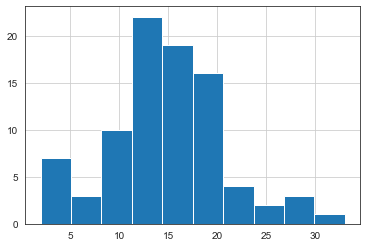

In [6]:
%matplotlib inline
units.groupby('action').count().unit_name.hist()

In [7]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=stim_mask, baseline_duration=baseline_duration
)

In [8]:
first_row = units[units['action'] == '1849-060319-3'].iloc[0]
#first_row = sessions.iloc[50]

In [20]:
def process(row):
    action_id = row['action']
    channel_id = row['channel_group']
    unit_id = row['unit_name']
    
    # common values for all units == faster calculations
    x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
#     ang, ang_t = map(data_loader.head_direction(action_id).get, ['a', 't'])
    
    occupancy_map = data_loader.occupancy(action_id)
    xbins, ybins = data_loader.spatial_bins
    box_size_, bin_size_ = data_loader.box_size_, data_loader.bin_size_
    prob_dist = data_loader.prob_dist(action_id)
    
#     smooth_low_occupancy_map = sp.maps.smooth_map(
#         occupancy_map, bin_size=bin_size_, smoothing=smoothing_low)
    smooth_high_occupancy_map = sp.maps.smooth_map(
        occupancy_map, bin_size=bin_size_, smoothing=smoothing_high)
            
    spike_times = data_loader.spike_train(action_id, channel_id, unit_id)
    if len(spike_times) == 0:
        result = pd.Series({
            'spatial_average_rate': np.nan
        })
        return result

    # common
    spike_map = sp.maps._spike_map(x, y, t, spike_times, xbins, ybins)

#     smooth_low_spike_map = sp.maps.smooth_map(spike_map, bin_size=bin_size_, smoothing=smoothing_low)
    smooth_high_spike_map = sp.maps.smooth_map(spike_map, bin_size=bin_size_, smoothing=smoothing_high)

#     smooth_low_rate_map = smooth_low_spike_map / smooth_low_occupancy_map
    smooth_high_rate_map = smooth_high_spike_map / smooth_high_occupancy_map

    

    tmp_rate_map = smooth_high_rate_map.copy()
    tmp_rate_map[np.isnan(tmp_rate_map)] = 0
    avg_rate = np.sum(np.ravel(tmp_rate_map * prob_dist))


    result = pd.Series({
        'spatial_average_rate': avg_rate
    })
    return result
        
process(first_row)

spatial_average_rate    3.181077
dtype: float64

In [ ]:
results = units.merge(
    units.progress_apply(process, axis=1), 
    left_index=True, right_index=True)

In [ ]:
output_path = pathlib.Path("output") / "calculate-statistics-extra"
output_path.mkdir(exist_ok=True)

In [ ]:
results.to_csv(output_path / "results.csv", index=False)

# Store results in Expipe action

In [ ]:
statistics_action = project.require_action("calculate-statistics-extra")

In [ ]:
statistics_action.data["results"] = "results.csv"
copy_tree(output_path, str(statistics_action.data_path()))

In [ ]:
statistics_action.modules['parameters'] = {
    'max_speed': max_speed,
    'min_speed': min_speed,
    'position_sampling_rate': position_sampling_rate,
    'position_low_pass_frequency': position_low_pass_frequency,
    'box_size': box_size,
    'bin_size': bin_size,
    'smoothing_low': smoothing_low,
    'smoothing_high': smoothing_high,
    'stim_mask': stim_mask,
    'baseline_duration': baseline_duration
}

In [ ]:
septum_mec.analysis.registration.store_notebook(statistics_action, "10_calculate_statistics_extra.ipynb")